In [1]:
# Repurposed SWRanalysis code to analyze powers for CA1 v. DG electrodes. Similar to
# Fig. 6 in Solomon NatComm 2018. Want to assess across different ranges for different filters
# a la Sullivan et al 2011

In [132]:
import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
from ptsa.data.filters import ButterworthFilter
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from copy import copy
from scipy import stats
import pickle
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/Downloads/ptsa_plot-master/')
sys.path.append('/home1/john/johnModules')
from brain_labels import MTL_labels, LTC_labels, PFC_labels, OTHER_labels, ALL_labels # all location labels
%load_ext autoreload
%autoreload
from general import *
from SWRmodule import *

df = get_data_index("r1") # all RAM subjects
exp = 'catFR1' # 'FR1' 'catFR1'
from brain_labels import HPC_labels, ENT_labels, PHC_labels, temporal_lobe_labels,\
                         MFG_labels, IFG_labels, nonHPC_MTL_labels, AMY_labels, ENTPHC_labels

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Ripples by patient looks like this:
R1015J: 480
R1024E: 300
R1032D: 2232
R1035M: 240
R1045E: 1800
R1061T: 1200
R1065J: 10500
R1066P: 696
R1083J: 252
R1086M: 432
R1089P: 900
R1102P: 720
R1105E: 300
R1108J: 7200
R1112M: 216
R1131M: 576
R1138T: 240
R1144E: 5400
R1157C: 1800
R1158T: 192
R1171M: 648
R1174T: 600
R1176M: 300
R1180C: 2349
R1188C: 300
R1204T: 900
R1207J: 948
R1217T: 300
R1227T: 240
R1230J: 600
R1236J: 1800
R1239E: 480
R1243T: 1200
R1245E: 300
R1254E: 600
R1275D: 600
R1278E: 882
R1293P: 300
R1303E: 300
R1310J: 1500
R1313J: 300
R1315T: 1500
R1320D: 912
R1330D: 984
R1332M: 1200
R1334T: 600
R1338T: 600
R1343J: 1200
R1348J: 300
R1354E: 732
R1366J: 432
R1367D: 756
R1368T: 408
R1374T: 576
R1380D: 1296
R1382T: 144
R1383J: 1008
R1385E: 576
R1386T: 144
R1387E: 288
R1393T: 288
R1396T: 288
R1397D: 576
R1398J: 288
R1413D: 300
R1415T: 288
R1422T: 432
R1427T: 576
R1436J: 144
R1445E: 144
R1448T: 288
R1449T: 432
R1450D: 1584
R1456D: 3168
R1465D: 1728
R1468J: 1512
R1476J: 5040
R1484T: 864
R1486J: 1728
R1488T: 620
R1497T: 1440
R1498D: 288
R1501J: 1008
R1515T: 1728
R1518T: 1008
R1525J: 9144

In [157]:
# sub lists I've been using to explore FR1 

# subs = ['R1002P','R1003P','R1006P','R1010J','R1112M','R1163T'] # initial 6 for hippocampus
# subs = subs+['R1001P','R1092J','R1151E','R1320D'] # additional subs with issues that I resolved with various RR and corr thresholds
# subs = ['R1112M','R1018P','R1020J','R1022J','R1023J','R1026D','R1027J'] # 7 with entorhinal
# subs = ['R1010J','R1112M'] # original 2 # R1108J beatiful catFR1 data; R1065J magical subject (like with FR1)
# subs = ['R1112M','R1163T'] # subjects with FR1 and catFR1. SRs of 1000 and 500 tho
# subs = ['R1151E'] # all channels X sessions get removed but 3 after 60/180 hz line removal
# these should all be worked out now. See SWR FR1 problem sessions PPT on Box for details of each
# subs = ['R1299T','R1332M','R1397D','R1349T','R1339D','R1337E','R1275D','R1151E','R1123C','R1120E','R1045E'] # final surrounding_recall problem subs after looking at huge raster!
# subs = ['R1308T','R1338T','R1358T'] # these guys had weird SRs and some loading problems when I went to whole_retrieval analysis...fixed with rounding
# subs = ['R1023J','R1101T','R1148P','R1368T','R1323T','R1334T'] # single session subs with memory allocation errors in ClusterRun
# subs = ['R1006P','R1010J','R1030J','R1032D','R1049J','R1051J','R1052E','R1054J','R1093J','R1098D','R1104D','R1108J','R1111M',
#         'R1115T','R1118N','R1124J','R1207J','R1230J','R1316T','R1329T','R1323T','R1337E','R1367D'] # subs that didn't load on 2020-07-04 encoding run
# subs = ['R1368T','R1461T','R1463E'] # subs with particularly low localization.pair matches in pairs...see Excel in loading info on Box for details
# subs = ['R1433E','R1355T','R1367D','R1368T'] # subs with "ca3" or "dg"
# subs = ['R1065J'] # subject with over 8000 FR1 trials X electrodes
# bad_subs = ['R1433E','R1051J'] # no electrode cats
# subs = ['R1379E','R1385E','R1387E','R1394E','R1402E'] # partial beep subs
# subs = ['R1379E','R1402E','R1396T','R1395M','R1415T','R1389J','R1404E']  # test subs for eeg offset correction
# subs = ['R1048E','R1054J'] # nice example FR1 subs
# subs = ['R1048E','R1112M'] # couple of FR1 subs
subs = ['R1144E'] #['R1065J'] # 'R1525J' master spectrogram looks a bit lighter
# subs = ['R1293P'] 
# subs = ['R1334T']

sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp)] # all sessions for subs
# sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp) & (df.session==1)] # single session
# sub_df = df[(df.experiment == exp) & (df.session == 0)] # all FR subs 
# sub_df = sub_df[0:1]
sub_df

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
819,NaN,protocols/r1/subjects/R1144E/experiments/catFR...,protocols/r1/subjects/R1144E/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1144E/experiments/catFR...,0,NaN,0,protocols/r1/subjects/R1144E/localizations/0/m...,NaN,0,R1144E,R1144E,NaN,protocols/r1/subjects/R1144E/experiments/catFR...
820,NaN,protocols/r1/subjects/R1144E/experiments/catFR...,protocols/r1/subjects/R1144E/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1144E/experiments/catFR...,0,NaN,1,protocols/r1/subjects/R1144E/localizations/0/m...,NaN,1,R1144E,R1144E,NaN,protocols/r1/subjects/R1144E/experiments/catFR...
821,NaN,protocols/r1/subjects/R1144E/experiments/catFR...,protocols/r1/subjects/R1144E/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1144E/experiments/catFR...,0,NaN,2,protocols/r1/subjects/R1144E/localizations/0/m...,NaN,2,R1144E,R1144E,NaN,protocols/r1/subjects/R1144E/experiments/catFR...


In [158]:
# 575 FR sessions. first 18 of don't load so skip those 
exp_df = df[df.experiment==exp]
if exp == 'FR1':
    exp_df = exp_df[
                    ((df.subject!='R1015J') | (df.session!=0)) & 
                    ((df.subject!='R1063C') | (df.session!=1)) & 
                    ((df.subject!='R1093J') | (~df.session.isin([1,2]))) &
                    ((df.subject!='R1100D') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1120E') | (df.session!=0)) &
                    ((df.subject!='R1122E') | (df.session!=2)) &
                    ((df.subject!='R1154D') | (df.session!=0)) &
                    ((df.subject!='R1186P') | (df.session!=0)) &
                    ((df.subject!='R1201P') | (~df.session.isin([0,1]))) &
                    ((df.subject!='R1216E') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1277J') | (df.session!=0)) &
                    ((df.subject!='R1413D') | (df.session!=0)) & 
                    ((df.subject!='R1123C') | (df.session!=2)) & # artifacts that bleed through channels (see SWR FR1 prob sessions ppt)
                    ((df.subject!='R1151E') | (~df.session.isin([1,2]))) & # more bleed-through artifacts (see same ppt)
                    ((df.subject!='R1275D') | (df.session!=3))  # 3rd session an actual repeat of 2nd session (Paul should have removed from database by now)
    #                 (df.subject!='R1065J') # sub with 9000 trials
                   ] 
elif exp == 'catFR1': 
    exp_df = exp_df[
                    ((df.subject!='R1044J') | (df.session!=0)) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1491T') | (~df.session.isin([1,3,5]))) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1486J') | (~df.session.isin([4,5,6,7]))) & # repeated data...will be removed at some point... @@
                    ((df.subject!='R1501J') | (~df.session.isin([0,1,2,3,4,5]))) & # these weren't catFR1 (and they don't load right anyway)
                    ((df.subject!='R1235E') | (df.session!=0)) & # split EEG filenames error...documented on Asana
                    ((df.subject!='R1310J') | (df.session!=1)) & # session 1 is just a repeat of session 0
                    ((df.subject!='R1239E') | (df.session!=0)) # some correlated noise (can see in catFR1 problem sessions ppt)
                    ]
elif exp == 'RepFR1':
    exp_df = exp_df[
                    (df.subject!='R1564J') # clearly something wrong with these EEG when looking at ripple raster
                    ]
exp_df.shape
# exp_df = exp_df[257:] # for catFR1 this is R1385E-onwwards
# exp_df = exp_df[472:] # for FR1 this is R1385E-onwwards
# exp_df = exp_df[-19:]
exp_df

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(519, 17)

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
24,NaN,protocols/r1/subjects/R1004D/experiments/catFR...,protocols/r1/subjects/R1004D/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1004D/experiments/catFR...,0,NaN,0,protocols/r1/subjects/R1004D/localizations/0/m...,NaN,0,R1004D,R1004D,NaN,protocols/r1/subjects/R1004D/experiments/catFR...
45,NaN,protocols/r1/subjects/R1013E/experiments/catFR...,protocols/r1/subjects/R1013E/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1013E/experiments/catFR...,1,NaN,0,protocols/r1/subjects/R1013E/localizations/0/m...,NaN,0,R1013E,R1013E_1,NaN,protocols/r1/subjects/R1013E/experiments/catFR...
58,NaN,protocols/r1/subjects/R1015J/experiments/catFR...,protocols/r1/subjects/R1015J/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1015J/experiments/catFR...,0,NaN,0,protocols/r1/subjects/R1015J/localizations/0/m...,NaN,0,R1015J,R1015J,NaN,protocols/r1/subjects/R1015J/experiments/catFR...
64,NaN,protocols/r1/subjects/R1016M/experiments/catFR...,protocols/r1/subjects/R1016M/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1016M/experiments/catFR...,0,NaN,0,protocols/r1/subjects/R1016M/localizations/0/m...,NaN,0,R1016M,R1016M,NaN,protocols/r1/subjects/R1016M/experiments/catFR...
65,NaN,protocols/r1/subjects/R1016M/experiments/catFR...,protocols/r1/subjects/R1016M/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1016M/experiments/catFR...,0,NaN,1,protocols/r1/subjects/R1016M/localizations/0/m...,NaN,1,R1016M,R1016M,NaN,protocols/r1/subjects/R1016M/experiments/catFR...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2655,NaN,protocols/r1/subjects/R1626S/experiments/catFR...,protocols/r1/subjects/R1626S/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1626S/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1626S/localizations/0/m...,NaN,0,R1626S,R1626S,3.4,protocols/r1/subjects/R1626S/experiments/catFR...
2656,NaN,protocols/r1/subjects/R1626S/experiments/catFR...,protocols/r1/subjects/R1626S/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1626S/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1626S/localizations/0/m...,NaN,2,R1626S,R1626S,3.4,protocols/r1/subjects/R1626S/experiments/catFR...
2657,NaN,protocols/r1/subjects/R1626S/experiments/catFR...,protocols/r1/subjects/R1626S/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1626S/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1626S/localizations/0/m...,NaN,3,R1626S,R1626S,3.4,protocols/r1/subjects/R1626S/experiments/catFR...
2658,NaN,protocols/r1/subjects/R1626S/experiments/catFR...,protocols/r1/subjects/R1626S/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1626S/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1626S/localizations/0/m...,NaN,4,R1626S,R1626S,3.4,protocols/r1/subjects/R1626S/experiments/catFR...


## bulk load data

In [159]:
## Now to load data from cluster, have to go through and append across sessions

### params that clusterRun used (note that exp is defined in first cell so can get exp_df above)
selected_period = 'encoding' # surrounding_recall # whole_retrieval # encoding 
recall_type_switch = 0

recall_minimum = 2000 # used if recall_type_switch = 3
region_name = 'HPC' #'ENT' #'HPC' #HPC_ENT #ENT #HPC # PHC 
remove_soz_ictal = 0
filter_type = 'hamming' #'butter' # butter/hamming/hamming125200
###

# get strings for path name for save and loading cluster data
if recall_type_switch in [0,4,6,8]:
    # for these I'm using all trials, but selecting for which recall after the fact
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,0,selected_period,recall_minimum)
else: # these others I haven't set up indexing (see >line 100 in this cell)
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
    
ripple_array = []; 
trial_nums = []; encoded_word_key_array = []
HPC_names = []; sub_sess_names = []
region_electrode_ct = []; sub_names = []
trial_by_trial_correlation = []; elec_ripple_rate_array = []
elec_by_elec_correlation = []; fr_array = []
list_num_key = []; session_events = pd.DataFrame()

serialpos_array = []; list_recall_num_array = []; # ~~~
rectime_array = []; recall_before_intrusion_array = []
recall_position_array = []; recall_index_array = []

electrode_labels = []; channel_coords = []; channel_nums = []

for row in sub_df.itertuples(): #sub_df.itertuples():  #half_df.itertuples(): ### DON'T CHANGE THIS TO EXP
    try:
        sub = row.subject; session = row.session; exp = row.experiment

        path_name = '/scratch/john/SWR_scratch/'+subfolder
        fn = os.path.join(path_name,
            'SWR_'+exp+'_'+sub+'_'+str(session)+'_'+region_name+'_'+selected_period+recall_selection_name+
                          '_'+soz_label+'_'+filter_type+'.p')   
        with open(fn,'rb') as f:
            dat = pickle.load(f)

            ripple_array = superVstack(ripple_array,dat['ripple_array']) 
            region_electrode_ct.append(dat['region_electrode_ct'])
            encoded_word_key_array.extend(dat['encoded_word_key_array'])
            HPC_names.extend(dat['HPC_names'])
            sub_sess_names.extend(dat['sub_sess_names'])
            sub_names.extend(dat['sub_names'])
            trial_nums = np.append(trial_nums,dat['trial_nums'])
            trial_by_trial_correlation.extend(dat['trial_by_trial_correlation']) # one value for each electrode for this session
            elec_by_elec_correlation = np.append(elec_by_elec_correlation,dat['elec_by_elec_correlation'])
            elec_ripple_rate_array.extend(dat['elec_ripple_rate_array']) # ripple rate by electrode so append
            #,'total_recalls':total_recalls, 'kept_recalls':kept_recalls}, f)
            if selected_period == 'whole_retrieval':
                if np.shape(dat['fr_array'])[0]!=np.shape(dat['ripple_array'])[0]:
                    print(sub+str(session))
                fr_array = superVstack(fr_array,dat['fr_array'])
            if selected_period == 'encoding':
                serialpos_array.extend(dat['serialpos_array'])
            if selected_period == 'surrounding_recall': # ~~~
                serialpos_array.extend(dat['serialpos_array']); list_recall_num_array.extend(dat['list_recall_num_array']) # ~~
                rectime_array.extend(dat['rectime_array']); recall_before_intrusion_array.extend(dat['recall_before_intrusion_array'])
                recall_position_array.extend(dat['recall_position_array']); recall_index_array.extend(dat['recall_index_array'])
            electrode_labels.extend(dat['electrode_labels'])
            channel_coords.extend(dat['channel_coords'])
            channel_nums.extend(dat['channel_nums'])
            list_num_key.extend(dat['list_num_key'])
            
            session_events = session_events.append(dat['session_events']) # doesn't append in place 

    except Exception as e:
        LogDFExceptionLine(row, e, 'ClusterLoadSWR_log.txt')  
print('** Done reading data for '+sub+' **')
        
# loading *all* the recalls with 0, but if it's 4 or 6 load just those trials

# trying new method of loading...translate these to ripple_array length dependent on recall_type_switch 
# (this way I can always load from recall_type_switch = 0)
subject_name_array,session_name_array,electrode_array,channel_coords_array,channel_nums_array = getSubSessPredictorsWithChannelNums(
        sub_names,sub_sess_names,trial_nums,electrode_labels,channel_coords,channel_nums)

# spread out encoded_word_key too so I know which words were correct
word_correct_array = []
for sess_elec in encoded_word_key_array:
    word_correct_array.append(sess_elec)
word_correct_array = np.array(word_correct_array)
word_correct_array[word_correct_array>0] = 1 # 1s and 2s are corrects

words_array = session_events.item_name.values
    
print('**Done translating to ripple_array frame**!!')
print('...')
print('% of all subjects for '+exp)
if exp == 'catFR1':
    len(np.unique(sub_names))/136*100 # % HPC subs for catFR1
    print('% of recalls for '+exp)
    ripple_array.shape[0]/50053*100 # % recalls for catFR1
if exp == 'FR1':
    len(np.unique(sub_names))/167*100 # % HPC subs for catFR1
    print('% of recalls for '+exp)
    ripple_array.shape[0]/60417*100 # % recalls for catFR1

** Done reading data for R1144E **
**Done translating to ripple_array frame**!!
...
% of all subjects for catFR1


0.7352941176470588

% of recalls for catFR1


20.378398897169

## only run next two cells if recalculating SWR recall times. for spectrograms skip down 2

In [160]:
select_subfield = True   # note: if you already ran this once, have to load again from data
                          # also this is only for HPC. So set to False for anywhere not in HPC like ENT and PHC
    
# select for subfield if HPC
if select_subfield == True:
    location_selected = 'ca1' #['ca1','dg'] #'dg' #'dg' # 'ca3' # 'dg' 'ca1' # sub # ['ca1','dg']
        # left # right # left hippocampus # right hippocampus # hippocampus
        # to see number of each: sum(np.array([names.find('sub') for names in HPC_names])>=0)
else:
    location_selected = ''
    

### Use a task condition to select recalls?? ###
### ...will select first one that's not 0    ###
select_ordinal_position = 0              # select only recalls at given output position. 0 means it's off ##DEPRECATED
select_list_position = 0 #[1,2,3] #[12]  # select only recalls at given position from encoding list. 
                                         # 0 means it's off. Must be list
select_less_than_rectime = 0             # select only recalls < this number % 5000
select_greater_than_rectime = 0          # select only recalls ≥ this number % 5000
select_lists_with_recalls = 0 # list(np.arange(3,13)) # [1] so this would select ≥4 recalls. Must be list hence the list(arange...)
                                         # select only recalls that come from lists with number in this list
select_intrusions_next = 0               # select recalls that lead to intrusions
    
if filter_type.find('hamming') != -1:
    desired_sample_rate = 500.
else:
    desired_sample_rate = 1000.
sr = desired_sample_rate # fixed at this value since this is the minimum across data and can always downsample
sr_factor = 1000/desired_sample_rate

print('Total electrodes loaded: '+str(len(trial_nums)))
print('from '+str(len(np.unique(sub_sess_names)))+' sessions from '+str(len(np.unique(sub_names)))+' subjects with trial nums:')
print(trial_nums[0:20])
print('Trial sum = '+str(np.sum(trial_nums)))
print(HPC_names[0:20])
print('Number of sub_sess names: '+str(len(sub_sess_names)))


start_array,end_array = getStartEndArrays(ripple_array); print('Got encoding start_array!')
 
# if selected an output position
if select_ordinal_position > 0:
    if np.min(ordinal_position_array) == 0: # only update this once (so don't have to reload data from files)
        ordinal_position_array = np.array(ordinal_position_array)+1 # now 1-indexed
    selected_recalls = ordinal_position_array==select_ordinal_position
elif type(select_list_position) == list:
    selected_recalls = [sp in select_list_position for sp in serialpos_array]
elif select_intrusions_next == 1:
    selected_recalls = np.array(recall_before_intrusion_array)==True
elif select_less_than_rectime > 0:
    selected_recalls = np.array(rectime_array)<select_less_than_rectime
elif select_greater_than_rectime > 0:
    selected_recalls = np.array(rectime_array)>=select_greater_than_rectime
elif type(select_lists_with_recalls) == list:
    selected_recalls = [recall in select_lists_with_recalls for recall in list_recall_num_array]
else:
    selected_recalls = np.ones(len(start_array),dtype=bool)
    
# get locations if selected

if select_subfield == True:
    # create the full vector of location name predictors
    location_names = []
    for s in range(len(HPC_names)):
        new_trials = int(trial_nums[s])
        location_names.extend(np.tile(HPC_names[s],new_trials))  
        
    # now can get mask of trials in this location
    
    #first, if there are two locations to combine, sort that out (DG and CA1 in particular)
    location_mask = np.zeros(len(location_names))
    for s in range(len(location_names)):
        if type(location_selected)==list:
            if location_names[s].find(location_selected[0])>=0 or location_names[s].find(location_selected[1])>=0:
                location_mask[s] = True
        elif type(location_selected)==str:
            if location_names[s].find(location_selected)>=0:
                location_mask[s] = True
else:
    location_mask = np.ones(len(start_array))

# DON'T USE temp_recall_idxs FOR ENCODING
# # gotta translate this to new frame as well from idxs in load step if selected subfield
# if select_subfield == True: 
#     location_mask = location_mask[temp_recall_idxs] 

# combine location and sorted recalls to get new ripple array:
updated_recalls = (location_mask+selected_recalls)==2

# this one list did not have 27 word presentations, so remove it
if exp == 'RepFR1':
    updated_recalls[(np.array(session_name_array)=='R1579T-1') & (np.array(list_num_key)==16)] = 0
    
# translate these predictors to vector and select recalls
start_array = start_array[updated_recalls]
end_array = end_array[updated_recalls] # used for duration calculations
subject_name_array = np.array(subject_name_array)[updated_recalls]
session_name_array = np.array(session_name_array)[updated_recalls]
electrode_array = np.array(electrode_array)[updated_recalls]
channel_coords_array = np.array(channel_coords_array)[updated_recalls]
channel_nums_array = np.array(channel_nums_array)[updated_recalls]
if selected_period in ['surrounding_recall','math','math_retrieval','whole_encoding','whole_retrieval']:
    list_recall_num_array = np.array(list_recall_num_array)[updated_recalls] # for subject-level analysis
# rectime_array = np.array(rectime_array)[updated_recalls]

# specific to encoding

# list_recall_num_array = np.array(list_recall_num_array)[updated_recalls]

# if selected_period in ['encoding','whole_encoding']:
encoded_word_key_array = np.array(encoded_word_key_array)[updated_recalls]
serialpos_array = np.array(serialpos_array)[updated_recalls]
list_num_key = np.array(list_num_key)[updated_recalls]

word_correct_array = word_correct_array[updated_recalls]
words_array = words_array[updated_recalls]
# recall_position_array = np.array(recall_position_array)[updated_recalls]
# if selected_period == 'encoding':    
#     session_events = session_events[updated_recalls]
    
print('Got start_array with '+str(start_array.shape[0])+' trials!')

sub_elec = [subject_name_array[i]+electrode_array[i] for i in range(len(electrode_array))]
print('Number of electrodes: '+str(len(np.unique(sub_elec))))
print('...from '+str(len(np.unique(subject_name_array)))+' patients')   

print('# of trials: '+str(np.shape(start_array)[0]))
print('Total # of ripples: '+str(sum(start_array)))
print('Overall ripple rate: '+str(np.round( (1000/sr_factor)*sum(start_array)/np.shape(start_array)[0]/np.shape(start_array)[1],3 ))+' Hz')

Total electrodes loaded: 34
from 3 sessions from 1 subjects with trial nums:
[300. 300. 300. 300. 300. 300. 300. 300. 300. 300. 300. 300. 300. 300.
 300. 300. 300. 300. 300. 300.]
Trial sum = 10200.0
['left sub', 'left dg', 'left ca1', 'left sub', 'left sub', 'left ca1', 'left ca1', 'left ca1', 'right ca1', 'right ca1', 'left sub', 'left dg', 'left ca1', 'left sub', 'left sub', 'left ca1', 'left sub', 'left ca1', 'left ca1', 'right hippocampus']
Number of sub_sess names: 34
Got encoding start_array!
Got start_array with 5400 trials!
Number of electrodes: 6
...from 1 patients
# of trials: 5400
Total # of ripples: 4821
Overall ripple rate: 0.298 Hz


In [161]:
len(start_array)
len(words_array)

5400

5400

## go through every recall trial, grab the times of the SWRs, and log in a df with the recall event index

In [162]:
# note: location is selected above using location_selected = XXX
#  so these are all from the same location

save_values = 1

SWR_df = pd.DataFrame()

print('Ripple rates for each channel in each session for subseqently remembered words:')
unique_sessions = np.unique(session_name_array)
for sub_sess in unique_sessions:
    sub = sub_sess.split('-')[0]
    session = int(sub_sess.split('-')[1])
    sub_sess_idx = (session_name_array==sub_sess) & (subject_name_array==sub) & (word_correct_array==1)
    session_start_array = start_array[sub_sess_idx]
    session_channel_nums_array = channel_nums_array[sub_sess_idx]
    
    session_word_correct_array = word_correct_array[sub_sess_idx]
    session_words_array = words_array[sub_sess_idx]    
    unique_channels = np.unique(session_channel_nums_array)
    
    for channel in unique_channels:
        channel_start_array = session_start_array[np.where(session_channel_nums_array==channel)[0]]
        channel_words_array = session_words_array[session_channel_nums_array==channel]
        print(sum(channel_start_array)/(3*len(channel_start_array)))
        for i in range(len(channel_start_array)):
            datarow = channel_start_array[i]
            
            SWR_starts = np.where(datarow)[0]            
            for ripple_time in SWR_starts:
                temp_time = (ripple_time*sr_factor)-700 # realign to 0
                temp_df = {'subject': sub, 'session': session,'word':channel_words_array[i],
                           'channel': channel, 'SWR_time': temp_time}  # *2 bc everything is at sr=500
                SWR_df = SWR_df.append(temp_df, ignore_index = True) 
                
    print('Number of SWRs: '+str(len(SWR_df)))                

if save_values == 1:
    path_name = '/home1/john/SWR/compiled/ENCODING/ripple_time_dfs/'
    if os.path.isdir(path_name) == False:
        os.mkdir(path_name)
    fn = os.path.join(path_name,
        'SWR_df_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+'_'+filter_type+'.p')            
    with open(fn,'wb') as f:
        pickle.dump({'SWR_df':SWR_df}, f)
    print('done saving')

Ripple rates for each channel in each session for subseqently remembered words:
0.44298245614035087
0.16228070175438597
0.2324561403508772
0.2719298245614035
0.39035087719298245
0.5219298245614035
Number of SWRs: 461
0.34959349593495936
0.18157181571815717
0.1897018970189702
0.2953929539295393
0.3523035230352303
0.3983739837398374
Number of SWRs: 1113
0.3967136150234742
0.15492957746478872
0.25821596244131456
0.3333333333333333
0.4272300469483568
0.5492957746478874
Number of SWRs: 2016
done saving


In [163]:
SWR_df

,SWR_time,channel,session,subject,word
0,648.0,11.0,0.0,R1144E,FINGERS
1,1216.0,11.0,0.0,R1144E,FINGERS
2,1008.0,11.0,0.0,R1144E,PLUM
3,1028.0,11.0,0.0,R1144E,HAWK
4,1422.0,11.0,0.0,R1144E,HAWK
...,...,...,...,...,...
2011,-36.0,83.0,2.0,R1144E,BINDER
2012,-22.0,83.0,2.0,R1144E,PEN
2013,-130.0,83.0,2.0,R1144E,COMPUTER
2014,1480.0,83.0,2.0,R1144E,ERASER


## load SWR_df and go through every sub_sess, grab the right recalls using recall_idx, and grab the eeg from every one

In [40]:
# run "## bulk load data" above with the sub_df you want first to get right setup variables then load from here:
location_selected = 'ca1' # 'ca1' '' for ENT or PHC

path_name = '/home1/john/SWR/compiled/ENCODING/ripple_time_dfs/'
fn = os.path.join(path_name,
    'SWR_df_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+'_'+filter_type+'.p') 
with open(fn,'rb') as f:
    dat = pickle.load(f)
    SWR_df = dat['SWR_df']
SWR_df

,recall_idx,subject,session,channel,SWR_time
0,38.0,R1065J,0.0,15.0,-1580.0
1,38.0,R1065J,0.0,15.0,370.0
2,91.0,R1065J,0.0,15.0,1016.0
3,91.0,R1065J,0.0,15.0,1754.0
4,91.0,R1065J,0.0,15.0,1782.0
...,...,...,...,...,...
2024,603.0,R1065J,5.0,148.0,1578.0
2025,628.0,R1065J,5.0,148.0,-1098.0
2026,628.0,R1065J,5.0,148.0,-538.0
2027,628.0,R1065J,5.0,148.0,-440.0


## get EEG!

In [164]:
from ptsa.data.filters import MorletWaveletFilter

save_values = 1

psth_start = -700
psth_end = 2300
eeg_buffer = 500
freqs = np.arange(25,250.1,1)
morlet_dist = 200 # how many ms to keep on either side of SWR_start
SWR_keep_range = [100,1700] # keep SWRs that occurred at these time points

for row in sub_df.itertuples(): #sub_df.itertuples():  #half_df.itertuples(): ### DON'T CHANGE THIS TO EXP
    
    SWR_keep = []
    sub = row.subject; session = row.session 

    if sum((SWR_df.session==session) & (SWR_df.subject==sub)) > 0: # if subject has electrodes in this location
    
        exp = row.experiment
        mont = int(row.montage); loc = int(row.localization)
        reader = CMLReadDFRow(row)
        pairs = reader.load('pairs')
        evs = reader.load('task_events')
        evs_encoding = evs[(evs.type=='WORD')]

        sub_sess_df = SWR_df[(SWR_df.subject==sub) & (SWR_df.session==session)]

        unique_word = np.unique(sub_sess_df.word)
        # take only evs that have subsequent recalls
        eeg_events = evs_encoding[np.array([rec in unique_word for rec in np.array(evs_encoding.item_name)])]

        # now get EEG for those recalls so can select from that 3D array using index and channel below
        
# no need for encoding
#         # but first correct the EEG
#         eeg_events = correctEEGoffset(sub,session,exp,reader,eeg_events)

        eeg = reader.load_eeg(events=eeg_events, rel_start=psth_start-eeg_buffer, 
                                  rel_stop=psth_end+eeg_buffer, clean=True, scheme=pairs) #**
        # events X electrodes X time
        sr = eeg.samplerate

        # if weird samplerate, add a few ms to make the load work
        if (499<sr<500) | (998<sr<1000):
            time_add = 1
            if (499<sr<500):
                sr = 500
            elif (998<sr<1000):
                sr = 1000
            while eeg.shape[2] < (psth_end-psth_start+2*eeg_buffer)/(1000/sr):
                eeg = reader.load_eeg(events=eeg_events, rel_start=psth_start-eeg_buffer,
                                      rel_stop=psth_end+eeg_buffer+time_add, clean=True, scheme=pairs)
                if time_add>50: #** 
                    continue
                time_add+=1
            eeg.samplerate = sr # need to overwrite those that were just fixed

        eeg_ptsa = eeg.to_ptsa()
        eeg = None # clear variable
        
        # don't need all these channels, so take only the good ones! but keep track of the numbers for later
        unique_channels = np.unique(sub_sess_df.channel)
        pair_names = [pairs.iloc[int(ch)].label for ch in unique_channels]
        eeg_ptsa = eeg_ptsa.sel(channel=pair_names)

        # line removal...don't do 120 for now
        eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[58.,62.], filt_type='stop', order=4).filter()
        eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[178.,182.], filt_type='stop', order=4).filter()

        # use PTSA Morlet
        wf = MorletWaveletFilter(timeseries=eeg_ptsa, freqs=freqs, width=5, output='power') # width is num_cycles 
        pow_wavelet = wf.filter()
        pows = pow_wavelet.data[:, :, :, int((eeg_buffer/1000.)*sr):-int((eeg_buffer/1000.)*sr)] # remove buffer
        pows = np.log10(pows) # freqs X evs X elecs X time
        # to plot in debugger: matshow(pows[:, event, channel, :], fignum=0, aspect='auto', cmap='RdBu_r'); show()

        for channel_idx in range(len(unique_channels)):
            ch_ripple_num = 0
            words = eeg_events.item_name.values
            for wrd in words:
                # for this channel and this recall in the EEG find all the ripple_starts
                recall_SWR_times = sub_sess_df[(sub_sess_df.channel==unique_channels[channel_idx]) \
                                             & (sub_sess_df.word==wrd)].SWR_time.values

                for recall_time in recall_SWR_times:
                    # make sure enough room on either side and it's in desired range to keep SWRs
                    if recall_time>=SWR_keep_range[0] and recall_time<=SWR_keep_range[1]: # abs(recall_time)<=(psth_end-morlet_dist) 
                        morlet_range = [(recall_time-morlet_dist-psth_start)/(1000/sr),(recall_time+morlet_dist-psth_start)/(1000/sr)]

                        # got EEG for each unique recall_idx so get idx in EEG for the right one
                        if len(np.where(words==wrd)[0])>1:
                            current_recall = int(np.where(words==wrd)[0][0]) # 2nd 0 in case there are two takes the 1st
                        else:
                            current_recall = int(np.where(words==wrd)[0]) 

                        # ripple X freq X time
                        SWR_keep.append(pows[:,current_recall,int(channel_idx),int(morlet_range[0]):int(morlet_range[1])])  
                        ch_ripple_num+=1
            print('Number of ripples in this channel: '+str(ch_ripple_num))

        # save separate for each sub
        if save_values == 1:
        
            from joblib import dump

            path_name = '/scratch/john/SWR_spectrograms/'
            if os.path.isdir(path_name) == False:
                os.mkdir(path_name)
            fn = os.path.join(path_name,
                'SWR_spect_'+sub+'_'+str(session)+'_'+exp+'_'+region_name+'_'+location_selected+'_'+selected_period+'_'+soz_label+'_'+filter_type+'.lzma')            
            with open(fn, 'wb') as f:
                dump(SWR_keep, f, compress=('lzma', 3))
            print('done saving '+sub+'-'+str(session))
            print(np.shape(SWR_keep))
print('*ALL* DONE')

/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1144E/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1144E/tal/R1144E_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1144E/experiments/catFR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1144E/eeg.noreref/R1144E_catFR1_0_21Feb16_1510.params.txt
/data/eeg/R1144E/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  3.531765937805176
Number of ripples in this channel: 58
Number of ripples in this channel: 28
Number of ripples in this channel: 28
Number of ripples in this channel: 39
Number of ripples in this channel: 44
Number of ripples in this channel: 71
done saving R1144E-0
(268, 226, 200)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1144E/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1144E/tal/R1144E_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1144E/experiments/catFR1/sessions/1/ephys/current_processed/sources.json
/data/eeg/R1144E/eeg.noreref/R1144E_catFR1_1_23Feb16_1218.params.txt
/data/eeg/R1144E/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  4.969480514526367
Number of ripples in this channel: 86
Number of ripples in this channel: 37
Number of ripples in this channel: 37
Number of ripples in this channel: 66
Number of ripples in this channel: 71
Number of ripples in this channel: 86
done saving R1144E-1
(383, 226, 200)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1144E/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1144E/tal/R1144E_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1144E/experiments/catFR1/sessions/2/ephys/current_processed/sources.json
/data/eeg/R1144E/eeg.noreref/R1144E_catFR1_2_24Feb16_1801.params.txt
/data/eeg/R1144E/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  5.927266836166382
Number of ripples in this channel: 103
Number of ripples in this channel: 34
Number of ripples in this channel: 57
Number of ripples in this channel: 73
Number of ripples in this channel: 105
Number of ripples in this channel: 123
done saving R1144E-2
(495, 226, 200)
*ALL* DONE


### # load and plot

In [165]:
from joblib import load
from scipy.signal import resample
path_name = '/scratch/john/SWR_spectrograms/'

location_selected = 'ca1' # 'ca1' 'dg'

# subs = ['R1083J'] single should be defined above but can define here if you ran half_df or exp_df instead
# sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp)] # all sessions for subs
# sub_df = sub_df[0:1]

first_append = 1 # not sure what this does...think it's only for averaging across subs
# use sub_df or half_df depending on what you want to average over
for row in sub_df.itertuples(): #sub_df.itertuples():  #half_df.itertuples(): ### DON'T CHANGE THIS TO EXP
    try:
        temp_SWR = []
        sub = row.subject; session = row.session; exp = row.experiment
        fn = os.path.join(path_name,
            'SWR_spect_'+sub+'_'+str(session)+'_'+exp+'_'+region_name+'_'+location_selected+'_'+selected_period+'_'+soz_label+'_'+filter_type+'.lzma')  
        with open(fn, 'rb') as f:
            temp_SWR = load(f)
            if np.shape(temp_SWR)[2] != 400: # if not sr=1000 with +/- 200 ms
                temp_SWR = resample(temp_SWR,400,axis=2)
            if first_append == 1: # identify where to create empty matrix
                print('first load for location '+location_selected)
                SWR_across_sessions = np.empty((0,np.shape(temp_SWR)[1],np.shape(temp_SWR)[2]))            
                first_append = 0
            SWR_across_sessions = np.append(SWR_across_sessions,temp_SWR,axis=0)    
        print('done loading '+sub+'_'+str(session)+' who has '+str(np.shape(temp_SWR)[0])+
              ' trials and '+str(np.shape(temp_SWR)[2])+' samples')
    except:
        continue
print('done with all of em!!')

first load for location ca1
done loading R1144E_0 who has 268 trials and 400 samples
done loading R1144E_1 who has 383 trials and 400 samples
done loading R1144E_2 who has 495 trials and 400 samples
done with all of em!!


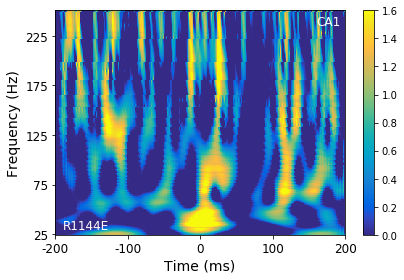

In [168]:
from general import parula_map

save_fig = 0
single_trial = 1

if single_trial == 1:

    trial = 0
    
    matshow(stats.zscore(SWR_across_sessions[trial,:,:],1), fignum=0, aspect='auto', cmap=parula_map, vmin=0, vmax=1.6) # 'viridis'
else:
    matshow(np.mean(stats.zscore(SWR_across_sessions,2), 0), fignum=0, aspect='auto', cmap=parula_map, vmin=0, vmax=1.6) # 'viridis'
    
# need these if didn't re-run 
freqs = np.arange(25,250.1,1)
morlet_dist = 200 # how many ms to keep on either side of SWR_start

# y-axis
gca().invert_yaxis()
ytick_size = 50
yticks(np.arange(0,len(freqs),ytick_size), np.arange(25,255.1,ytick_size,dtype=int), fontsize=12) # positions, labels
# setp(gca().get_yticklabels()[::2], visible=False) # get every other
ylabel('Frequency (Hz)', fontsize=14)

# x-axis
gca().xaxis.set_ticks_position('bottom')
xtick_size = 100
xticks(np.arange(0,2*morlet_dist+0.1,xtick_size), np.arange(-200,200+0.1,xtick_size,dtype=int),fontsize=12)
# setp(gca().get_xticklabels()[::2], visible=False)
xlabel('Time (ms)', fontsize=14)

text(10,5,sub,size=12,color=[1,1,1])
if location_selected == '':
    text(360,211,region_name,size=12,color=[1,1,1])
else:
    text(360,211,location_selected.upper(),size=12,color=[1,1,1])
if single_trial != 1:
    text(10,211,str(np.shape(SWR_across_sessions)[0])+' ripples',size=12,color=[1,1,1])
colorbar()
tight_layout()

if save_fig == 1:
    if single_trial == 1:
        fname = '/home1/john/SWR/figures/spectrograms/single_trials/'+sub+'_'+region_name+'_'+\
            location_selected+'_'+filter_type+'_'+str(np.shape(SWR_across_sessions)[0])+'_trial-'+str(trial)+'.pdf'
    else:
        fname = '/home1/john/SWR/figures/spectrograms/'+sub+'_'+region_name+'_'+\
            location_selected+'_'+str(np.shape(SWR_across_sessions)[0])+'_'+filter_type+'_ripples.pdf'        
    savefig(fname,format='pdf')
a=1;

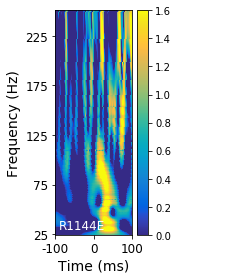

In [242]:
# make skinnier plots for Fig. 1

# R1065J, session 0, 'ca1', trial 0,6,7,13,31,39
# R1048E, session 0, ca1, trial 0, 6, 

save_fig = 1

subplots(1,1,figsize=(4,4))
start = 100
end = 300

if single_trial == 1:

    trial = 60
    
    matshow(stats.zscore(SWR_across_sessions[trial,:,start:end],1), fignum=0, aspect='auto', cmap=parula_map, vmin=0, vmax=1.6) # 'viridis'
else:
    matshow(np.mean(stats.zscore(SWR_across_sessions[:,:,start:end],2), 0), fignum=0, aspect='auto', cmap=parula_map, vmin=0, vmax=1.6) # 'viridis'

# y-axis
gca().invert_yaxis()
ytick_size = 50
yticks(np.arange(0,len(freqs),ytick_size), np.arange(25,255.1,ytick_size,dtype=int), fontsize=12) # positions, labels
# setp(gca().get_yticklabels()[::2], visible=False) # get every other
ylabel('Frequency (Hz)', fontsize=14)

# x-axis
gca().xaxis.set_ticks_position('bottom')
xtick_size = 100
xticks(np.arange(0,2*100+0.1,xtick_size), np.arange(-100,100+0.1,xtick_size,dtype=int),fontsize=12)
# setp(gca().get_xticklabels()[::2], visible=False)
xlabel('Time (ms)', fontsize=14)

text(10,5,sub,size=12,color=[1,1,1])
if location_selected == '':
    text(360,211,region_name,size=12,color=[1,1,1])
else:
    text(360,211,location_selected.upper(),size=12,color=[1,1,1])
if single_trial != 1:
    text(3,211,str(np.shape(SWR_across_sessions)[0])+' ripples',size=12,color=[1,1,1])
colorbar()
tight_layout()

if save_fig == 1:
    if single_trial == 1:
        fname = '/home1/john/SWR/figures/spectrograms/single_trials/small-'+sub+'_'+region_name+'_'+\
            location_selected+'_'+selected_period+'_'+filter_type+'_'+str(np.shape(SWR_across_sessions)[0])+'_trial-'+str(trial)+'_'+str(recall_type_switch)+'.pdf'
    else:
        fname = '/home1/john/SWR/figures/spectrograms/small-'+sub+'_'+region_name+'_'+\
            location_selected+'_'+selected_period+'_'+str(np.shape(SWR_across_sessions)[0])+'_'+filter_type+'_ripples.pdf'        
    savefig(fname,format='pdf')
a=1;

In [36]:
np.shape(SWR_across_sessions)
np.shape(eeg_ptsa)
len(SWR_df)

(972, 226, 400)

(83, 9, 5000)

1061

In [19]:
np.mean(stats.zscore(SWR_across_sessions[start:end],2), 0).shape
stats.zscore(SWR_across_sessions[trial,:,start:end],1).shape

(226, 400)

(226, 200)

In [24]:
SWR_across_sessions[trial,:,start:end].shape

(226, 200)